In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# get the py files to import later
import sys
sys.path.append('/content/drive/MyDrive/YoutubeImagePyFiles')


In [ ]:
!pip install git+https://github.com/Zeecka/pytube@fix_1060#egg=pytube

  Cloning https://github.com/Zeecka/pytube (to revision fix_1060) to /tmp/pip-install-djt6sdj8/pytube_b585ac7d78284b67807d5099c749f673
  Running command git clone -q https://github.com/Zeecka/pytube /tmp/pip-install-djt6sdj8/pytube_b585ac7d78284b67807d5099c749f673
  Running command git checkout -b fix_1060 --track origin/fix_1060
  Switched to a new branch 'fix_1060'
  Branch 'fix_1060' set up to track remote branch 'fix_1060' from 'origin'.
  Created wheel for pytube: filename=pytube-10.9.3-py3-none-any.whl size=55893 sha256=4622c48255ea4a7cab08dbf06a720518d041519f3b1b710a959819b59d6d2ac6
  Stored in directory: /tmp/pip-ephem-wheel-cache-xnszvflc/wheels/c5/98/55/13acb9c3b78204cd531a41bab32197a08de6a26fbb66b60f0a
Successfully built pytube


In [ ]:
!pip install --upgrade pytube

     |████████████████████████████████| 56 kB 2.3 MB/s 
  Attempting uninstall: pytube
    Found existing installation: pytube 10.9.3
    Uninstalling pytube-10.9.3:
      Successfully uninstalled pytube-10.9.3


In [ ]:
from pytube import YouTube

import os
import shutil
import math
import datetime
import glob
import numpy as np
import tensorflow as tf
import pickle


# plots
import matplotlib.pyplot as plt
%matplotlib inline

import cv2

from tqdm import tqdm
from tensorflow.keras import layers
from tensorflow.keras.layers import MaxPool2D,Conv2D,UpSampling2D,Input,Dropout
from tensorflow.keras.layers import Reshape, Conv2DTranspose, concatenate, Rescaling
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

from tensorflow.keras.layers import Activation, Dense, Dropout, Flatten, InputLayer, BatchNormalization, LeakyReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import img_to_array

# Download images from YouTube

In [ ]:
# create the instance of the YouTube class
video = YouTube('https://www.youtube.com/watch?v=OrzM0Vi35rg')

In [ ]:
video.streams.all()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated function all (This object can be treated as a list, all() is useless).
  """Entry point for launching an IPython kernel.


[<Stream: itag="17" mime_type="video/3gpp" res="144p" fps="8fps" vcodec="mp4v.20.3" acodec="mp4a.40.2" progressive="True" type="video">,
 <Stream: itag="18" mime_type="video/mp4" res="360p" fps="30fps" vcodec="avc1.42001E" acodec="mp4a.40.2" progressive="True" type="video">,
 <Stream: itag="22" mime_type="video/mp4" res="720p" fps="30fps" vcodec="avc1.64001F" acodec="mp4a.40.2" progressive="True" type="video">,
 <Stream: itag="571" mime_type="video/mp4" res="4320p" fps="60fps" vcodec="av01.0.17M.08" progressive="False" type="video">,
 <Stream: itag="315" mime_type="video/webm" res="2160p" fps="60fps" vcodec="vp9" progressive="False" type="video">,
 <Stream: itag="401" mime_type="video/mp4" res="2160p" fps="60fps" vcodec="av01.0.13M.08" progressive="False" type="video">,
 <Stream: itag="308" mime_type="video/webm" res="1440p" fps="60fps" vcodec="vp9" progressive="False" type="video">,
 <Stream: itag="400" mime_type="video/mp4" res="1440p" fps="60fps" vcodec="av01.0.12M.08" progressive="

In [ ]:
# mp4 version
video.streams.filter(file_extension = "mp4").all()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated function all (This object can be treated as a list, all() is useless).
  


[<Stream: itag="18" mime_type="video/mp4" res="360p" fps="30fps" vcodec="avc1.42001E" acodec="mp4a.40.2" progressive="True" type="video">,
 <Stream: itag="22" mime_type="video/mp4" res="720p" fps="30fps" vcodec="avc1.64001F" acodec="mp4a.40.2" progressive="True" type="video">,
 <Stream: itag="571" mime_type="video/mp4" res="4320p" fps="60fps" vcodec="av01.0.17M.08" progressive="False" type="video">,
 <Stream: itag="401" mime_type="video/mp4" res="2160p" fps="60fps" vcodec="av01.0.13M.08" progressive="False" type="video">,
 <Stream: itag="400" mime_type="video/mp4" res="1440p" fps="60fps" vcodec="av01.0.12M.08" progressive="False" type="video">,
 <Stream: itag="299" mime_type="video/mp4" res="1080p" fps="60fps" vcodec="avc1.64002a" progressive="False" type="video">,
 <Stream: itag="399" mime_type="video/mp4" res="1080p" fps="60fps" vcodec="av01.0.09M.08" progressive="False" type="video">,
 <Stream: itag="298" mime_type="video/mp4" res="720p" fps="60fps" vcodec="avc1.4d4020" progressive=

In [ ]:
video.streams.get_by_itag(18).download()

'/content/France in 8K ULTRA HD - King of France is Paris !.mp4'

In [ ]:
class FrameExtractor():
    '''
    Class used for extracting frames from a video file.
    '''
    def __init__(self, video_path):
        self.video_path = video_path
        self.vid_cap = cv2.VideoCapture(video_path)
        self.n_frames = int(self.vid_cap.get(cv2.CAP_PROP_FRAME_COUNT))
        self.fps = int(self.vid_cap.get(cv2.CAP_PROP_FPS))
        
    def get_video_duration(self):
        '''Method for printing the video's duration'''
        duration = self.n_frames/self.fps
        print(f'Duration: {datetime.timedelta(seconds=duration)}')
        
    def get_n_images(self, every_x_frame):
        '''
        Method for calculating the expected number of images to save given 
        we save every x-th frame
        
        Parameters
        ----------
        
        every_x_frame : int
            Indicates we want to look at every x-th frame
        '''
        n_images = math.floor(self.n_frames / every_x_frame) + 1
        print(f'Extracting every {every_x_frame} (nd/rd/th) frame would result in {n_images} images.')
        
    def extract_frames(self, every_x_frame, img_name, dest_path=None, img_ext = '.jpg'):
        '''
        Method used for extracting the frames from images
        
        Parameters
        ----------
        
        every_x_frame : int
            Indicates we want to extract every x-th frame
        img_name : str
            The image name, numbers will be appended (after an underscore) at the end
        dest_path : str
            The path where to store the images. Default (None) saves the images to current directory.
        img_ext : str
            Indicates the desired extension of the image. Default is JPG
        '''
        if not self.vid_cap.isOpened():
            self.vid_cap = cv2.VideoCapture(self.video_path)
        
        if dest_path is None:
            dest_path = os.getcwd()
        else:
            if not os.path.isdir(dest_path):
                os.mkdir(dest_path)
                print(f'Created the following directory: {dest_path}')
        
        frame_cnt = 0
        img_cnt = 0

        while self.vid_cap.isOpened():
            
            success,image = self.vid_cap.read() 
            
            if not success:
                break
            
            if frame_cnt % every_x_frame == 0:
                img_path = os.path.join(dest_path, ''.join([img_name, '_', str(img_cnt), img_ext]))
                cv2.imwrite(img_path, image)  
                img_cnt += 1
                
            frame_cnt += 1
        
        self.vid_cap.release()
        cv2.destroyAllWindows()

'''reference about how to download the images from youtube https://github.com/erykml/video_games_colorization'''

'reference about how to download the images from youtube https://github.com/erykml/video_games_colorization'

In [ ]:
# instantiate the class using the downloaded video
fe = FrameExtractor('France in 8K ULTRA HD - King of France is Paris !.mp4')

In [ ]:
# print the number of frames in the video
fe.n_frames

36317

In [ ]:
# print the video's duration
fe.get_video_duration()

Duration: 0:20:10.566667


In [ ]:
# calculate the potential number of frames 
fe.get_n_images(every_x_frame=20)

Extracting every 20 (nd/rd/th) frame would result in 1816 images.


In [ ]:
# extract every 20 frame
fe.extract_frames(every_x_frame=20, 
                  img_name='paris', 
                  dest_path='images')

Created the following directory: images


# Preprocess data

In [ ]:
# shutil.rmtree('/content/images')

In [ ]:
root_dir = '/content/images' 

# split the whole images into 80% and 20% for train and test set 
all_image_files = os.listdir(root_dir)
np.random.shuffle(all_image_files)

train_fnames, test_fnames = np.split(np.array(all_image_files), [int(len(all_image_files)*(1 - 0.2))])

train_fnames = [root_dir + '/' + name for name in train_fnames.tolist()]
test_fnames = [root_dir + '/' + n for n in test_fnames.tolist()]

print(len(train_fnames))
print(len(test_fnames))

1452
364


# Split the dataset

In [ ]:
# data folder structure
'''
image
   train
     -- trainColor
     -- trainGray
   test
     -- testColor
     -- testGray
'''

train_cls = 'train'
test_cls = 'test'
train_data = os.path.join(root_dir, train_cls) #/content/images/train
test_data = os.path.join(root_dir, test_cls) 

# Generate the color train and gray folder
train_color = 'trainColor'
train_gray = 'trainGray'

# Generate the grayscale train and grayscale test
test_color = 'testColor'
test_gray = 'testGray'

train_color_path = os.path.join(train_data, train_color) # '/content/images/train/trainColor'
test_color_path = os.path.join(test_data, test_color) # /content/images/test/testColor

train_gray_path = os.path.join(train_data, train_gray) # '/content/images/train/trainGray'
test_gray_path = os.path.join(test_data, test_gray) # 'testGray'

# make path
os.makedirs(train_color_path, exist_ok=True)
os.makedirs(test_color_path, exist_ok=True)
os.makedirs(train_gray_path, exist_ok=True)
os.makedirs(test_gray_path, exist_ok=True)


# copy images into color train and test folders
for file in train_fnames:
  shutil.copy(file, train_color_path)

for f in test_fnames:
  shutil.copy(f, test_color_path)



# Generate the gray images from original images


1.   Use OpenCV
2.   Convert BGR to RGB because openCV read images in BGR format
3.   Convert the images to grayscale
4.   Assign the images into **train gray** and **test gray**



In [ ]:
# make gray images for train and test folders

for file in train_fnames:
  img = cv2.imread(file)
  img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
  cv2.imwrite(os.path.join(train_gray_path, file[16:]), gray) # file only contain the image name


for name in test_fnames:
  img_1 = cv2.imread(name)
  rgb = cv2.cvtColor(img_1, cv2.COLOR_BGR2RGB)
  gray_1 = cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)
  cv2.imwrite(os.path.join(test_gray_path, name[16:]), gray_1)



# Scaling 



1.   Set image size to 160
2.   Resize
3.   Normalization
4.   Store the images into lists based on their classes



In [ ]:
# scale train color and train gray images
img_size = 160

color_imgs = []
for lst in tqdm(os.listdir(train_color_path)):
  image = cv2.imread(train_color_path + '/' + lst)
  image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image_rgb = cv2.resize(image_rgb, (img_size, img_size))
  image_rgb = image_rgb.astype('float32') / 255.0
  color_imgs.append(img_to_array(image_rgb))

gray_imgs = []
for l in tqdm(os.listdir(train_gray_path)):
  gray_img = cv2.imread(train_gray_path + '/' + l)
  gray_img = cv2.resize(gray_img, (img_size, img_size))
  gray_img = gray_img.astype('float32') / 255.0
  gray_imgs.append(img_to_array(gray_img))

100%|██████████| 1452/1452 [00:05<00:00, 289.13it/s]


In [ ]:
# scaling for test data
color_imgs_t = []
for item in tqdm(os.listdir(test_color_path)):
  pic = cv2.imread(test_color_path + '/' + item)
  # open cv reads images in BGR format so we have to convert it to RGB
  pic_rgb = cv2.cvtColor(pic, cv2.COLOR_BGR2RGB)
  pic_rgb = cv2.resize(pic_rgb, (img_size, img_size))
  pic_rgb = pic_rgb.astype('float32') / 255.0
  color_imgs_t.append(img_to_array(pic_rgb))

gray_imgs_t = []
for i in tqdm(os.listdir(test_gray_path)):
  gray_pic = cv2.imread(test_gray_path + '/' + i)
  gray_pic = cv2.resize(gray_pic, (img_size, img_size))
  gray_pic = gray_pic.astype('float32') / 255.0
  gray_imgs_t.append(img_to_array(gray_pic))

100%|██████████| 364/364 [00:01<00:00, 282.56it/s]


# Preview the images



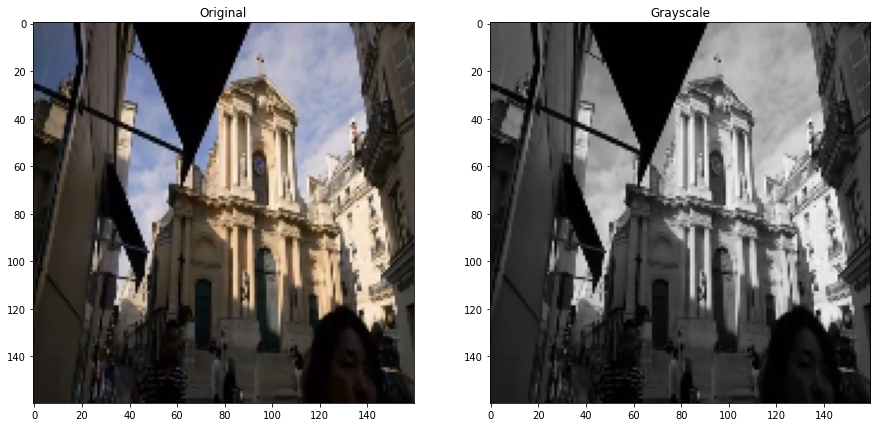

In [ ]:
# define a function for viewing images in color and grayscale

plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.title('Original')
plt.imshow(color_imgs[200])

plt.subplot(1,2,2)
plt.title('Grayscale')
plt.imshow(gray_imgs[200])

In [ ]:
# reshape 
train_original = np.reshape(color_imgs, (len(color_imgs),img_size,img_size,3))
train_grayscale = np.reshape(gray_imgs,(len(gray_imgs),img_size,img_size,3))

print('Train color image shape:',train_original.shape)

test_original = np.reshape(color_imgs_t, (len(color_imgs_t),img_size,img_size,3))
test_grayscale = np.reshape(gray_imgs_t,(len(gray_imgs_t),img_size,img_size,3))

Train color image shape: (1452, 160, 160, 3)


# Model training

Downsampling and upsampling

In [ ]:
def downsampling(filters , kernel_size, apply_batch_normalization = True):
    downsample = Sequential()
    downsample.add(Conv2D(filters,kernel_size,padding = 'same', strides = 2))
    if apply_batch_normalization:
        downsample.add(BatchNormalization())
    downsample.add(LeakyReLU())
    return downsample


def upsampling(filters, kernel_size, dropout = False):
    upsample = Sequential()
    upsample.add(Conv2DTranspose(filters, kernel_size,padding = 'same', strides = 2))
    if dropout:
        upsample.dropout(0.2)
    upsample.add(LeakyReLU())
    return upsample

In [ ]:
def model():
    inputs = Input(shape= [img_size,img_size,3])
    d1 = downsampling(128,(3,3),False)(inputs)
    d2 = downsampling(128,(3,3),False)(d1)
    d3 = downsampling(256,(3,3),True)(d2)
    d4 = downsampling(512,(3,3),True)(d3)
    d5 = downsampling(512,(3,3),True)(d4)

    #upsampling
    u1 = upsampling(512,(3,3),False)(d5)
    u1 = layers.concatenate([u1,d4])
    u2 = upsampling(256,(3,3),False)(u1)
    u2 = layers.concatenate([u2,d3])
    u3 = upsampling(128,(3,3),False)(u2)
    u3 = layers.concatenate([u3,d2])
    u4 = upsampling(128,(3,3),False)(u3)
    u4 = layers.concatenate([u4,d1])
    u5 = upsampling(3,(3,3),False)(u4)
    u5 = layers.concatenate([u5,inputs])
    output = Conv2D(3,(2,2),strides = 1, padding = 'same')(u5)
    return Model(inputs=inputs, outputs=output)

In [ ]:
model = model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 80, 80, 128)  3584        ['input_1[0][0]']                
                                                                                                  
 sequential_1 (Sequential)      (None, 40, 40, 128)  147584      ['sequential[0][0]']             
                                                                                                  
 sequential_2 (Sequential)      (None, 20, 20, 256)  296192      ['sequential_1[0][0]']       

In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = 'mean_absolute_error',
              metrics = ['acc'])

model.fit(train_grayscale, train_original, batch_size = 64, epochs=50)

Epoch 1/50
23/23 [==============================] - 28s 689ms/step - loss: 0.1418 - acc: 0.3027
Epoch 2/50
23/23 [==============================] - 14s 606ms/step - loss: 0.0851 - acc: 0.3614
Epoch 3/50
23/23 [==============================] - 14s 608ms/step - loss: 0.0787 - acc: 0.4224
Epoch 4/50
23/23 [==============================] - 14s 612ms/step - loss: 0.0744 - acc: 0.4544
Epoch 5/50
23/23 [==============================] - 14s 614ms/step - loss: 0.0677 - acc: 0.4849
Epoch 6/50
23/23 [==============================] - 14s 618ms/step - loss: 0.0644 - acc: 0.5059
Epoch 7/50
23/23 [==============================] - 14s 617ms/step - loss: 0.0618 - acc: 0.5181
Epoch 8/50
23/23 [==============================] - 14s 619ms/step - loss: 0.0577 - acc: 0.5466
Epoch 9/50
23/23 [==============================] - 14s 619ms/step - loss: 0.0541 - acc: 0.5680
Epoch 10/50
23/23 [==============================] - 14s 619ms/step - loss: 0.0502 - acc: 0.5945
Epoch 11/50
23/23 [====================

In [ ]:
model.save('AutoEncode_colorise_images.h5')

# Predict

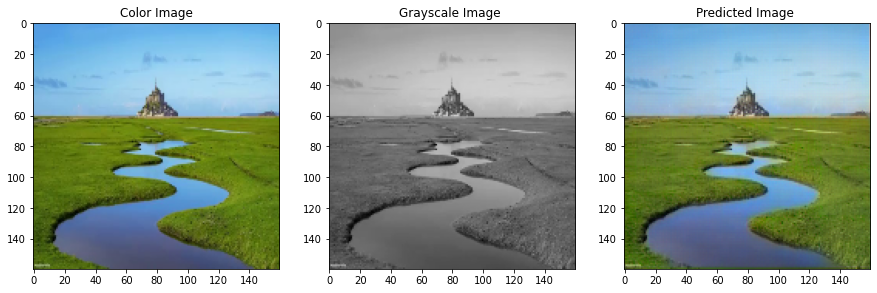

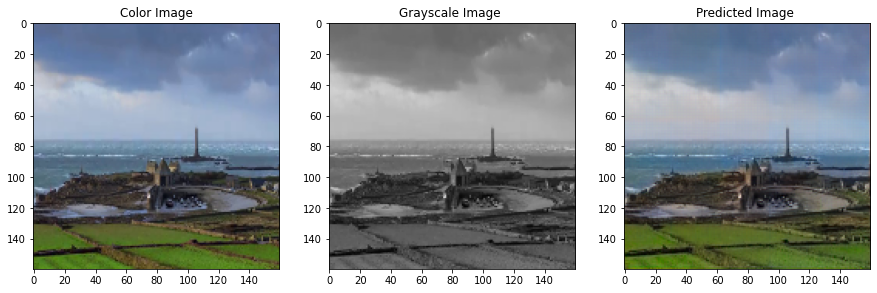

In [ ]:
def plot_images(color,grayscale,predicted):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('Color Image')
    plt.imshow(color)
    plt.subplot(1,3,2)
    plt.title('Grayscale Image ')
    plt.imshow(grayscale)
    plt.subplot(1,3,3)
    plt.title('Predicted Image ')
    plt.imshow(predicted)
   
    plt.show()

for i in range(168,170):
    predicted = np.clip(model.predict(gray_imgs_t[i].reshape(1,img_size, img_size,3)),0.0,1.0).reshape(img_size, img_size,3)
    plot_images(color_imgs_t[i],gray_imgs_t[i],predicted)